# 第九章 正则化 

## 9.1 归纳偏执

### P211  任务之间的相似性假设代表了一种比简单正则化更复杂的归纳偏置形式，这解释了使用额外数据（微调/迁移学习）带来的性能提升

**归纳偏置（Inductive Bias）：**

对于一个有限数据集 $\{x_1, \ldots, x_n\}$ 对应的 $\{t_1, \ldots, t_n\}$，有无限个 $W$ 满足的假设。
所以需要引入**归纳偏置**，挑出最有泛化性的那个分布。


**e.g. 加入正则项** → 防止权重过大 → 曲线（分布）更平滑

$$
E'(w) = E(w) + \frac{\lambda}{2} w^T w
$$

**e.g. CNN** → 通过 kernel 的“扫描”加入平移不变性

**e.g. 迁移学习** → 以一个**预训练**好的模型作为先验。



**？ 引入物理/化学公式也是一种归纳偏置**

**？ 偏置**

有倾向的**对待假设**，根据先验，体现我们希望分布是什么样的

Inductive Bias = 引导某个学习算法的偏置（带倾向）


**？ 归纳偏置是决定分布一开始在哪里，还是决定分布往哪里走？** → 都可以，看形式

**？ 什么样的问题需要引入什么样的归纳偏置处理？**

结构偏置（e.g. CNN 平移不变）→ 模型能表达的东西（时序、图像等）→ 模型结构

方向偏置（e.g. 风格迁移，内容loss和风格loss同时优化）→ 更新方向 → loss 设计 → 加入物理公式

起点偏置（e.g. 预训练，参数初始化）→ 初始位置

## 9.3 学习曲线

### P233  随机梯度下降下隐含的隐性偏见产生了良好的泛化能力


#### 1. SGD 的隐性偏见机制

$$w_{t+1} = w_t - \eta \nabla L(w_t)$$

* 每次用一个小批样本 → 随机性 → 每次取样本都有误差 → 实际最小化 $L(w) + \lambda R(w)$ → 在有多个可能零误差解时，趋向于“**平滑**”的解（例如最小范数、低复杂度）
* 随机性让参数在狭窄处难以收敛，易于跳出尖锐极小值，从而更好泛化



#### 2. 参数量与泛化（图9.10）

| 参数量（模型大小） | 有效参数（随训练轮数）                           |
| --------- | -------------------------------------- | 
| 小         | 无法很好拟合，总体增大                                 | 
| 中         | 逐渐增加，先拟合后过拟合                                   | 
| 大         | 过拟合后随 epoch 增大，SGD 会倾向于更平滑的解，从而有更好的泛性 |




☆ 随机性让参数在狭窄处发散，难以停住（收敛？）

☆ 大模型有更多“平滑”解可选



#### 3. Adam vs SGD

**Adam：**

$$w_{t+1} = w_t - \eta_t \frac{m_t}{\sqrt{v_t} + \varepsilon}$$

“自适应缩放” → 打破统一噪声分布

☆ Adam 收敛速度快，但**泛化不一定比 SGD 好**

[SGD] Epoch 1: loss=2.2385
[SGD] Epoch 2: loss=2.1462
[SGD] Epoch 3: loss=1.9381
[SGD] Epoch 4: loss=1.6858
[SGD] Epoch 5: loss=1.5437
[SGD] Epoch 6: loss=1.3585
[SGD] Epoch 7: loss=1.2356
[SGD] Epoch 8: loss=1.1709
[SGD] Epoch 9: loss=0.9866
[SGD] Epoch 10: loss=0.8028
[SGD] Epoch 11: loss=0.5923
[SGD] Epoch 12: loss=0.3845
[SGD] Epoch 13: loss=0.2730
[SGD] Epoch 14: loss=0.1360
[SGD] Epoch 15: loss=0.0847
[SGD] Epoch 16: loss=0.0318
[SGD] Epoch 17: loss=0.0178
[SGD] Epoch 18: loss=0.0147
[SGD] Epoch 19: loss=0.0156
[SGD] Epoch 20: loss=0.0181
[SGD] Epoch 21: loss=0.0253
[SGD] Epoch 22: loss=0.0223
[SGD] Epoch 23: loss=0.0217
[SGD] Epoch 24: loss=0.0215
[SGD] Epoch 25: loss=0.0160
[SGD] Epoch 26: loss=0.0078
[SGD] Epoch 27: loss=0.0048
[SGD] Epoch 28: loss=0.0041
[SGD] Epoch 29: loss=0.0032
[SGD] Epoch 30: loss=0.0026
[SGD] Epoch 31: loss=0.0022
[SGD] Epoch 32: loss=0.0020
[SGD] Epoch 33: loss=0.0018
[SGD] Epoch 34: loss=0.0015
[SGD] Epoch 35: loss=0.0018
[SGD] Epoch 36: loss=0.0014
[

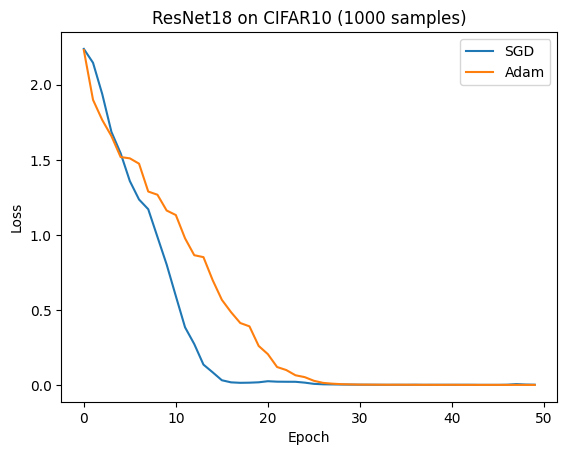

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import random, numpy as np
import matplotlib.pyplot as plt

# ============ 1. 随机种子与设备 ============
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============ 2. 数据集准备 ============
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet 输入大小
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# 只取子集：1000 train, 200 test
train_idx = list(range(1000))
test_idx = list(range(200))
train_subset = torch.utils.data.Subset(trainset, train_idx)
test_subset = torch.utils.data.Subset(testset, test_idx)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False)

# ============ 3. 定义模型与损失 ============
def make_model():
    model = resnet18(weights=None, num_classes=10)
    return model.to(device)

model_sgd = make_model()
model_adam = make_model()
criterion = nn.CrossEntropyLoss()

# ============ 4. 定义优化器 ============
opt_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)
opt_adam = optim.Adam(model_adam.parameters(), lr=0.001)

# ============ 5. 训练函数 ============
def train(model, optimizer, name):
    losses = []
    for epoch in range(50):  # 训练 10 轮即可
        model.train()
        total_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(trainloader)
        losses.append(avg_loss)
        print(f"[{name}] Epoch {epoch+1}: loss={avg_loss:.4f}")
    return losses

# ============ 6. 训练 ============
loss_sgd = train(model_sgd, opt_sgd, "SGD")
loss_adam = train(model_adam, opt_adam, "Adam")

# ============ 7. 测试准确率 ============
def test(model, name):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"[{name}] Test Accuracy: {acc:.2f}%")
    return acc

acc_sgd = test(model_sgd, "SGD")
acc_adam = test(model_adam, "Adam")

# ============ 8. 绘制收敛曲线 ============
plt.plot(loss_sgd, label='SGD')
plt.plot(loss_adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ResNet18 on CIFAR10 (1000 samples)')
plt.legend()
plt.show()


#### 4. 为什么还要显式正则
**加快收敛速度**，直接避免过拟合阶段。

在pytorch中，DataLoader 是迭代器，所以一个epoch应该会遍历所有的数据，是无放回采样的。但是SGD本身应该是有放回的采样，这样会有什么影响吗？

##### 1. 有放回与无放回采样的区别

* **有放回采样（With Replacement）**：
  每次抽样后会将样本放回集合，因此某些样本可能在同一轮中被多次抽到，且每次抽样都是独立的。

* **无放回采样（Without Replacement）**：
  每次抽样后不会将样本放回集合，因此每个样本只能被使用一次，样本之间的关系是相关的。

##### 2. 数学推导：采样方差的差异

假设我们有一组样本$ \{ x_1, x_2, \dots, x_N \} $，每个样本对应一个损失函数值 $\ell(x_i)$，我们希望计算每个批次的梯度估计。

**2.1 有放回采样的方差**

在**有放回采样**的情况下，假设每次抽取一个 mini-batch，大小为 ( m )：

$$
g_t = \frac{1}{m} \sum_{i \in \mathcal{B}_t} \nabla \ell(w_t; x_i)
$$

由于每次抽样是独立的，我们可以得到采样方差为：

$$
\text{Var}[g_t] = \frac{1}{m} \Sigma(w_t)
$$

其中 $\Sigma(w_t)$ 是整个数据集的梯度方差。

**2.2 无放回采样的方差**

在**无放回采样**的情况下，每次抽样后的样本不会被放回，所以下次抽样时可选择的样本会减少。统计学中这被称为“有限总体修正”：

$$
\text{Var}[g_t] = \frac{1}{m} \left( 1 - \frac{m-1}{N-1} \right) \Sigma(w_t)
$$

这表明，当样本数较多时，无放回采样的方差会比有放回采样稍微小一些，因为每次抽样之间有一定的相关性。特别是随着 ( N ) 趋于无穷大时，**方差差距**会变得很小。

**2.3 总结**

* **有放回采样**：每次抽样是独立的，采样方差始终为 $\frac{1}{m} \Sigma(w_t)$。
* **无放回采样**：由于每次抽样后样本数减少，采样方差会随样本数量变化，变得稍微更小。

##### 3. 对比与影响

* **有放回采样**的噪声通常是稳定的，但每次都能“独立”更新，比较适合 **更大规模的数据集**，能够保持训练的稳定性。

* **无放回采样**会随着训练进度逐渐减少噪声，因为随着样本逐步消耗，估计的方差变小。它适合**小数据集**，能够有效避免过多的噪声。

通过这些差异，我们可以得到如下的影响：

* **无放回采样**会让噪声逐渐衰减，有助于在训练后期更快速的收敛。
* **有放回采样**则保持了较恒定的噪声，适合长期训练，能在长时间的训练中逐步降低过拟合的风险。



## 9.4 参数共享

### P234 简单的权重衰减正则化器可以看作是权重上的高斯先验分布的负对数

高斯先验是一个钟形曲线，最高点在 $w=0$。
负对数之后，其形状变成：

* 一个以 $0$ 为最低点的抛物线
* 离 $0$ 越远，惩罚越大

即 L2 正则项的形状。
